In [89]:
import pandas as pd
import numpy as np
import seaborn as sns
from nltk.corpus import wordnet
import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from wordcloud import WordCloud
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# About Dataset
Abstract: Real online reviews from Amazon.

Data source: https://www.amazon.com/REDTIGER-Display-Dashboard-Recorder-Support/product-reviews/B08TT1RRGP/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=

In [2]:
content_data=pd.read_csv('Amazon_review.csv')
content_data.head()

,prodect,title,rating,country,date,body,help_people
0,REDTIGER F7N 4K Dual Dash Cam Built-in WiFi GP...,Camera is great… The hardwire kit is another s...,5.0,United States,2021-06-28,The Redtiger 4K camera is awesome! It works am...,303
1,REDTIGER F7N 4K Dual Dash Cam Built-in WiFi GP...,Nice,5.0,United States,2021-05-30,It advertised with free hardwire kit. Hardwire...,129
2,REDTIGER F7N 4K Dual Dash Cam Built-in WiFi GP...,Hardwire /Parking mode feature doesn’t work,1.0,United States,2021-06-01,"Can’t get the the parking mode to work, I’ve p...",414
3,REDTIGER F7N 4K Dual Dash Cam Built-in WiFi GP...,Not optimized as a Dash Cam/APP doesn't connect,1.0,United States,2021-09-04,The camera itself is great other than the 1/3/...,264
4,REDTIGER F7N 4K Dual Dash Cam Built-in WiFi GP...,My never turned on!!,1.0,United States,2021-06-28,The media could not be loaded.\n ...,259


# Understanding data

In [3]:
content_data.shape

(742, 7)

In [4]:
content_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 742 entries, 0 to 741
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   prodect      742 non-null    object 
 1   title        742 non-null    object 
 2   rating       742 non-null    float64
 3   country      742 non-null    object 
 4   date         742 non-null    object 
 5   body         739 non-null    object 
 6   help_people  742 non-null    int64  
dtypes: float64(1), int64(1), object(5)
memory usage: 40.7+ KB


<AxesSubplot:xlabel='rating', ylabel='count'>

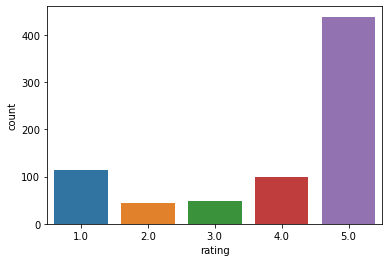

In [5]:
sns.countplot(data=content_data, x='rating')

In [6]:
def get_tag(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def clean_text(comment):
    comment=str(comment)
    comment=comment.lower()
    comment=[word.strip(string.punctuation)for word in comment.split(' ')]
    comment=[word for word in comment if not any(d.isdigit() for d in word)]

    stop_word=stopwords.words('english')
    comment=[word for word in comment if word not in stop_word]
    comment=[word for word in comment if len(word)>0]
    pos=pos_tag(comment)
    comment=[WordNetLemmatizer().lemmatize(word[0], get_tag(word[1])) for word in pos]
    comment=[word for word in comment if len(word)>1]
    comment=' '.join(comment)

    return(comment)


content_data['cleaned_body']=content_data['body'].apply(lambda x : clean_text(x))
    

In [7]:
content_data.head()

,prodect,title,rating,country,date,body,help_people,cleaned_body
0,REDTIGER F7N 4K Dual Dash Cam Built-in WiFi GP...,Camera is great… The hardwire kit is another s...,5.0,United States,2021-06-28,The Redtiger 4K camera is awesome! It works am...,303,redtiger camera awesome work amazingly well wo...
1,REDTIGER F7N 4K Dual Dash Cam Built-in WiFi GP...,Nice,5.0,United States,2021-05-30,It advertised with free hardwire kit. Hardwire...,129,advertised free hardwire kit hardwire kit univ...
2,REDTIGER F7N 4K Dual Dash Cam Built-in WiFi GP...,Hardwire /Parking mode feature doesn’t work,1.0,United States,2021-06-01,"Can’t get the the parking mode to work, I’ve p...",414,can’t get parking mode work i’ve purchase hard...
3,REDTIGER F7N 4K Dual Dash Cam Built-in WiFi GP...,Not optimized as a Dash Cam/APP doesn't connect,1.0,United States,2021-09-04,The camera itself is great other than the 1/3/...,264,camera great recording option option use conti...
4,REDTIGER F7N 4K Dual Dash Cam Built-in WiFi GP...,My never turned on!!,1.0,United States,2021-06-28,The media could not be loaded.\n ...,259,medium could loaded.\n \n\n\n\n never turn


In [8]:
model=SentimentIntensityAnalyzer()
content_data['sentiment'] = content_data['cleaned_body'].apply(lambda x: model.polarity_scores(x))
content_data=pd.concat([content_data, content_data['sentiment'].apply(pd.Series)],axis=1)
content_data.drop('sentiment',axis=1, inplace=True)


In [9]:
content_data

,prodect,title,rating,country,date,body,help_people,cleaned_body,neg,neu,pos,compound
0,REDTIGER F7N 4K Dual Dash Cam Built-in WiFi GP...,Camera is great… The hardwire kit is another s...,5.0,United States,2021-06-28,The Redtiger 4K camera is awesome! It works am...,303,redtiger camera awesome work amazingly well wo...,0.065,0.664,0.271,0.9381
1,REDTIGER F7N 4K Dual Dash Cam Built-in WiFi GP...,Nice,5.0,United States,2021-05-30,It advertised with free hardwire kit. Hardwire...,129,advertised free hardwire kit hardwire kit univ...,0.050,0.749,0.200,0.8481
2,REDTIGER F7N 4K Dual Dash Cam Built-in WiFi GP...,Hardwire /Parking mode feature doesn’t work,1.0,United States,2021-06-01,"Can’t get the the parking mode to work, I’ve p...",414,can’t get parking mode work i’ve purchase hard...,0.124,0.835,0.041,-0.4019
3,REDTIGER F7N 4K Dual Dash Cam Built-in WiFi GP...,Not optimized as a Dash Cam/APP doesn't connect,1.0,United States,2021-09-04,The camera itself is great other than the 1/3/...,264,camera great recording option option use conti...,0.123,0.738,0.139,0.2500
4,REDTIGER F7N 4K Dual Dash Cam Built-in WiFi GP...,My never turned on!!,1.0,United States,2021-06-28,The media could not be loaded.\n ...,259,medium could loaded.\n \n\n\n\n never turn,0.000,1.000,0.000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...
737,Customer reviews: REDTIGER F7N 4K Dual Dash Ca...,It refuses to stay on it gets overheated and s...,4.0,United States,2021-09-30,The camera runs for a little bit and then gets...,0,camera run little bit get overheat shut within...,0.063,0.540,0.397,0.9217
738,Customer reviews: REDTIGER F7N 4K Dual Dash Ca...,This is exactly what I was looking for.,5.0,United States,2021-08-12,The media could not be loaded.\n ...,0,medium could loaded.\n \n\n\n\n this exactly l...,0.000,0.729,0.271,0.9920
739,Customer reviews: REDTIGER F7N 4K Dual Dash Ca...,Quality.,5.0,United States,2022-01-18,Legal purposes in case i'm in ana accident or ...,0,legal purpose case i'm ana accident witness one,0.292,0.566,0.142,-0.3818
740,Customer reviews: REDTIGER F7N 4K Dual Dash Ca...,Great product,5.0,United States,2021-05-18,A driving recorder is needed in every car. Pre...,0,drive recorder need every car prevent car scra...,0.000,0.774,0.226,0.4215


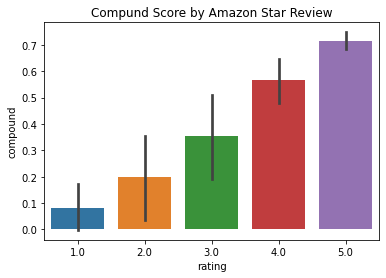

In [10]:
plot = sns.barplot(data=content_data, x='rating', y='compound')
plot.set_title('Compund Score by Amazon Star Review')
plt.show()

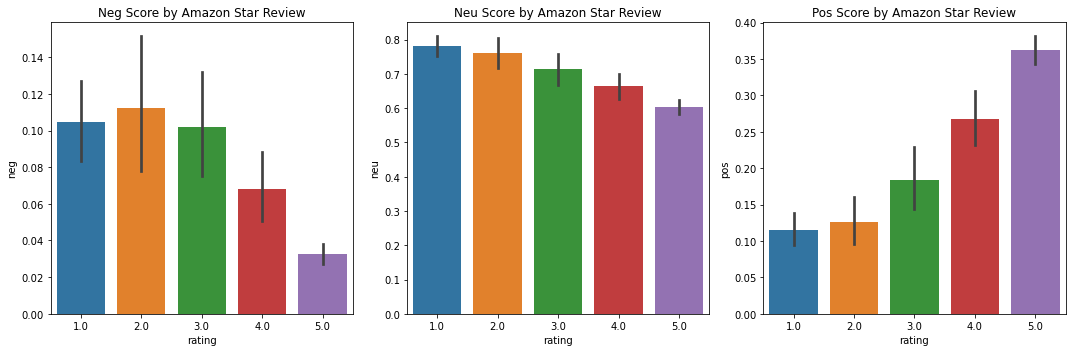

In [11]:
fig, axs=plt.subplots(1,3, figsize=(15,5))
sns.barplot(data=content_data, x='rating', y='neg', ax=axs[0])
sns.barplot(data=content_data, x='rating', y='neu', ax=axs[1])
sns.barplot(data=content_data, x='rating', y='pos', ax=axs[2])
axs[0].set_title('Neg Score by Amazon Star Review')
axs[1].set_title('Neu Score by Amazon Star Review')
axs[2].set_title('Pos Score by Amazon Star Review')

plt.tight_layout()
plt.show()

<AxesSubplot:xlabel='compound', ylabel='Count'>

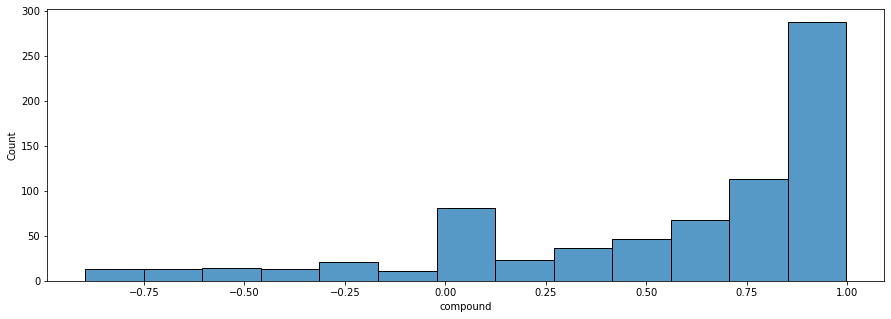

In [12]:
fig,ax=plt.subplots(1,1,figsize=(15,5))

sns.histplot(data=content_data, x='compound', ax=ax)


In [13]:
content_data['compound_level']=content_data['compound'].apply(lambda x : 'Negitive' if x <0 else( 'Netural' if x<0.5 else 'Positive' ))

In [14]:
content_data['compound_level'].value_counts()

Positive    480
Netural     177
Negitive     85
Name: compound_level, dtype: int64

<AxesSubplot:xlabel='compound_level', ylabel='rating'>

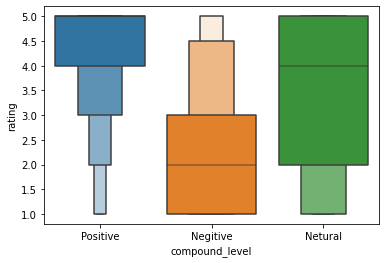

In [15]:
sns.boxenplot(data=content_data, x='compound_level', y='rating')

In [16]:
content_data['rating_level']=content_data['rating'].apply(lambda x : 'Negitive' if x <3 else( 'Netural' if x <4 else 'Positive'))

In [17]:
content_data['rating_level'].value_counts()

Positive    536
Negitive    158
Netural      48
Name: rating_level, dtype: int64

In [18]:
pred_data, true_data=content_data['compound_level'].tolist(), content_data['rating_level'].tolist()

In [19]:
len(pred_data), len(true_data)

(742, 742)

In [20]:
matrix=confusion_matrix(true_data,pred_data,  labels=['Negitive', 'Netural','Positive'])

Text(114.0, 0.5, 'True')

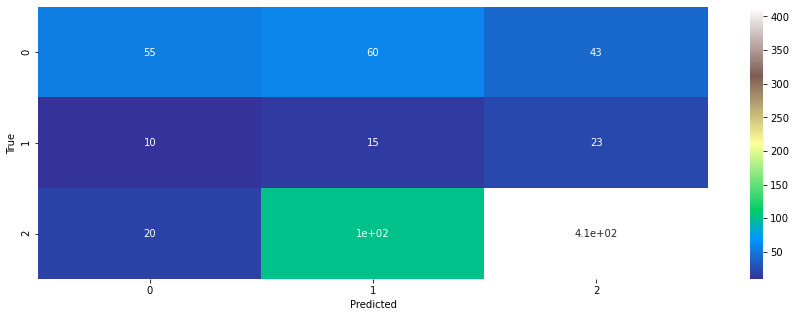

In [21]:
fig, axx=plt.subplots(1,1, figsize=(15,5))
sns.heatmap(data=matrix, cmap='terrain', annot=True, ax=axx)
axx.set_xlabel('Predicted')
axx.set_ylabel('True')


# Performance Assessment

### Positive Sentiment Prediction Assessment

In [22]:
tp, tn, fp, fn= 410, 55+60+10+15, 42+23, 20+100
precision = tp/(tp+fp)*100

print(f'Precision: {round(precision,2)}%')

Precision: 86.32%


### Negative Sentiment Prediction Assessment

In [23]:
tp, tn, fp, fn= 55, 15+23+100+410, 10+20, 60+43
neg_precision = tp/(tp+fp)*100

print(f'Precision: {round(neg_precision,2)}%')

Precision: 64.71%


# Feature engineering

In [24]:
content_data

,prodect,title,rating,country,date,body,help_people,cleaned_body,neg,neu,pos,compound,compound_level,rating_level
0,REDTIGER F7N 4K Dual Dash Cam Built-in WiFi GP...,Camera is great… The hardwire kit is another s...,5.0,United States,2021-06-28,The Redtiger 4K camera is awesome! It works am...,303,redtiger camera awesome work amazingly well wo...,0.065,0.664,0.271,0.9381,Positive,Positive
1,REDTIGER F7N 4K Dual Dash Cam Built-in WiFi GP...,Nice,5.0,United States,2021-05-30,It advertised with free hardwire kit. Hardwire...,129,advertised free hardwire kit hardwire kit univ...,0.050,0.749,0.200,0.8481,Positive,Positive
2,REDTIGER F7N 4K Dual Dash Cam Built-in WiFi GP...,Hardwire /Parking mode feature doesn’t work,1.0,United States,2021-06-01,"Can’t get the the parking mode to work, I’ve p...",414,can’t get parking mode work i’ve purchase hard...,0.124,0.835,0.041,-0.4019,Negitive,Negitive
3,REDTIGER F7N 4K Dual Dash Cam Built-in WiFi GP...,Not optimized as a Dash Cam/APP doesn't connect,1.0,United States,2021-09-04,The camera itself is great other than the 1/3/...,264,camera great recording option option use conti...,0.123,0.738,0.139,0.2500,Netural,Negitive
4,REDTIGER F7N 4K Dual Dash Cam Built-in WiFi GP...,My never turned on!!,1.0,United States,2021-06-28,The media could not be loaded.\n ...,259,medium could loaded.\n \n\n\n\n never turn,0.000,1.000,0.000,0.0000,Netural,Negitive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
737,Customer reviews: REDTIGER F7N 4K Dual Dash Ca...,It refuses to stay on it gets overheated and s...,4.0,United States,2021-09-30,The camera runs for a little bit and then gets...,0,camera run little bit get overheat shut within...,0.063,0.540,0.397,0.9217,Positive,Positive
738,Customer reviews: REDTIGER F7N 4K Dual Dash Ca...,This is exactly what I was looking for.,5.0,United States,2021-08-12,The media could not be loaded.\n ...,0,medium could loaded.\n \n\n\n\n this exactly l...,0.000,0.729,0.271,0.9920,Positive,Positive
739,Customer reviews: REDTIGER F7N 4K Dual Dash Ca...,Quality.,5.0,United States,2022-01-18,Legal purposes in case i'm in ana accident or ...,0,legal purpose case i'm ana accident witness one,0.292,0.566,0.142,-0.3818,Negitive,Positive
740,Customer reviews: REDTIGER F7N 4K Dual Dash Ca...,Great product,5.0,United States,2021-05-18,A driving recorder is needed in every car. Pre...,0,drive recorder need every car prevent car scra...,0.000,0.774,0.226,0.4215,Netural,Positive


In [25]:
convert_body = [TaggedDocument(doc, [i]) for i, doc in enumerate(content_data['cleaned_body'].apply(lambda x : x.split(' ')))]
# train a Doc2Vec model with our text data
model = Doc2Vec(convert_body, vector_size=5, window=2, min_count=1, workers=4)
# transform each document into a vector data
doc2vec = content_data["cleaned_body"].apply(lambda x: model.infer_vector(x.split(" "))).apply(pd.Series)
doc2vec.columns=['vector_'+ str(x) for x in doc2vec.columns]

data=pd.concat([content_data, doc2vec], axis=1)

data

,prodect,title,rating,country,date,body,help_people,cleaned_body,neg,neu,pos,compound,compound_level,rating_level,vector_0,vector_1,vector_2,vector_3,vector_4
0,REDTIGER F7N 4K Dual Dash Cam Built-in WiFi GP...,Camera is great… The hardwire kit is another s...,5.0,United States,2021-06-28,The Redtiger 4K camera is awesome! It works am...,303,redtiger camera awesome work amazingly well wo...,0.065,0.664,0.271,0.9381,Positive,Positive,1.292030,0.495630,0.649104,-1.081225,0.184337
1,REDTIGER F7N 4K Dual Dash Cam Built-in WiFi GP...,Nice,5.0,United States,2021-05-30,It advertised with free hardwire kit. Hardwire...,129,advertised free hardwire kit hardwire kit univ...,0.050,0.749,0.200,0.8481,Positive,Positive,1.247706,0.364882,0.520910,-0.829512,0.156339
2,REDTIGER F7N 4K Dual Dash Cam Built-in WiFi GP...,Hardwire /Parking mode feature doesn’t work,1.0,United States,2021-06-01,"Can’t get the the parking mode to work, I’ve p...",414,can’t get parking mode work i’ve purchase hard...,0.124,0.835,0.041,-0.4019,Negitive,Negitive,0.989891,0.287294,0.123219,-0.314592,0.043214
3,REDTIGER F7N 4K Dual Dash Cam Built-in WiFi GP...,Not optimized as a Dash Cam/APP doesn't connect,1.0,United States,2021-09-04,The camera itself is great other than the 1/3/...,264,camera great recording option option use conti...,0.123,0.738,0.139,0.2500,Netural,Negitive,0.744614,0.468881,0.621732,-0.820467,0.059333
4,REDTIGER F7N 4K Dual Dash Cam Built-in WiFi GP...,My never turned on!!,1.0,United States,2021-06-28,The media could not be loaded.\n ...,259,medium could loaded.\n \n\n\n\n never turn,0.000,1.000,0.000,0.0000,Netural,Negitive,0.206941,0.106154,0.157823,-0.236165,-0.120209
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
737,Customer reviews: REDTIGER F7N 4K Dual Dash Ca...,It refuses to stay on it gets overheated and s...,4.0,United States,2021-09-30,The camera runs for a little bit and then gets...,0,camera run little bit get overheat shut within...,0.063,0.540,0.397,0.9217,Positive,Positive,0.332987,0.140730,0.112299,-0.305094,0.184494
738,Customer reviews: REDTIGER F7N 4K Dual Dash Ca...,This is exactly what I was looking for.,5.0,United States,2021-08-12,The media could not be loaded.\n ...,0,medium could loaded.\n \n\n\n\n this exactly l...,0.000,0.729,0.271,0.9920,Positive,Positive,2.188468,0.936348,1.289114,-1.981944,0.123848
739,Customer reviews: REDTIGER F7N 4K Dual Dash Ca...,Quality.,5.0,United States,2022-01-18,Legal purposes in case i'm in ana accident or ...,0,legal purpose case i'm ana accident witness one,0.292,0.566,0.142,-0.3818,Negitive,Positive,0.260273,0.168989,0.221334,-0.291111,-0.046866
740,Customer reviews: REDTIGER F7N 4K Dual Dash Ca...,Great product,5.0,United States,2021-05-18,A driving recorder is needed in every car. Pre...,0,drive recorder need every car prevent car scra...,0.000,0.774,0.226,0.4215,Netural,Positive,0.443927,0.266358,0.345120,-0.479899,0.007811


In [26]:
vectorizer = TfidfVectorizer(min_df = 10)
tfidf = vectorizer.fit_transform(data["cleaned_body"]).toarray()
tfidf_df = pd.DataFrame(tfidf, columns = vectorizer.get_feature_names())
data_df = pd.concat([data, tfidf_df], axis=1)


# Data Analysis

### Frequent words

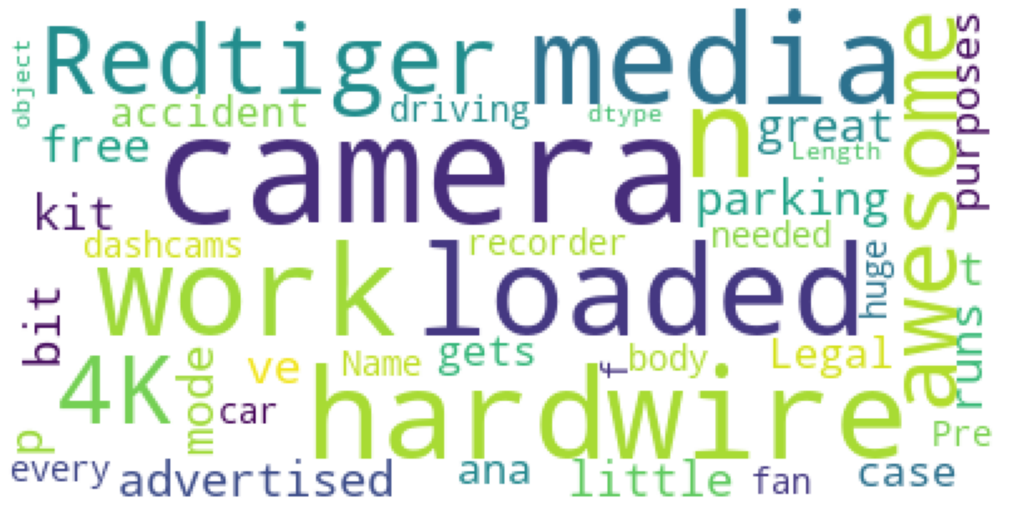

In [27]:
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(background_color = 'white',
                         max_font_size = 60).generate(str(data))

    fig = plt.figure(1, figsize = (18, 10))
    plt.axis('off')

    plt.imshow(wordcloud)
    plt.show()
    
# print wordcloud
show_wordcloud(data_df["body"])

### Bad or neutral reviews percentage

In [28]:
data_df['Not positive']=data_df['rating_level'].apply(lambda x :  False if 'Positive' in x else True)

In [29]:
data_df['Not positive'].value_counts()

False    536
True     206
Name: Not positive, dtype: int64

In [126]:
F=536
T=206


percentage=(T)/(F+T)*100

print(f'Bad or neutral reviews percentage: {round(percentage,2)}%')

Bad or neutral reviews percentage: 27.76%


In [127]:
False_total=data_df[data_df['Not positive']==False]['help_people'].sum()
True_total=data_df[data_df['Not positive']==True]['help_people'].sum()

percentage=(T_number+T)/(F_number+T_number+P+F)*100

print(f'Bad or neutral reviews with number of people who found it helpful percentage: {round(percentage,2)}%')


Bad or neutral reviews with number of people who found it helpful percentage: 44.75%


### Top 10 negitive reviews

In [31]:
data_df['number_word']=data_df['body'].apply(lambda x : len(str(x).split(' ')))
data_df[data_df['number_word']>5].sort_values('pos', ascending=False)[['body','pos']].head(10)


,body,pos
252,"Camera is amazing, best value for the money! T...",0.863
661,Works great and quality and clarity is great!,0.845
235,This camera is very nice i like it,0.841
186,Great quality and very responsive and helpful ...,0.834
587,I bought this product as a birthday gift for m...,0.794
303,Awesome camera with super wide view! Very impr...,0.784
502,Love this unit. Just wish it was wireless.,0.775
688,I love it so much thank you so much :),0.770
218,Great quality! Worth it! 4K quality!,0.750
306,"Great video quality and super clear , easy to ...",0.747


### Top 10 positive reviews

In [32]:
data_df[data_df['number_word']>5].sort_values('neg', ascending=False)[['body','pos']].head(10)


,body,pos
314,We have been rear-ended and tired of the liers...,0.000
603,"Too hard too use, too bad pics were goodReturned",0.000
558,the app sucks and its complicated,0.000
569,Use for 3-4 weeks. Can not turn on. Died!,0.000
563,Dislike did not for front camera not in box?,0.000
474,The unit's rear camera stopped working after o...,0.144
455,"Quality video, but accessing the data should n...",0.110
534,Multiple times while driving I noticed this ca...,0.000
531,video playback lagging even if you use high en...,0.000
542,The app for this camera is pathetic can’t even...,0.000


# Detect bad and neutral reviews

### train model

In [33]:
data_df

,prodect,title,rating,country,date,body,help_people,cleaned_body,neg,neu,...,worth,would,write,wrong,year,yet,you,youtube,Not positive,number_word
0,REDTIGER F7N 4K Dual Dash Cam Built-in WiFi GP...,Camera is great… The hardwire kit is another s...,5.0,United States,2021-06-28,The Redtiger 4K camera is awesome! It works am...,303,redtiger camera awesome work amazingly well wo...,0.065,0.664,...,0.000000,0.082795,0.0,0.0,0.0,0.0,0.0,0.0,False,113
1,REDTIGER F7N 4K Dual Dash Cam Built-in WiFi GP...,Nice,5.0,United States,2021-05-30,It advertised with free hardwire kit. Hardwire...,129,advertised free hardwire kit hardwire kit univ...,0.050,0.749,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,False,95
2,REDTIGER F7N 4K Dual Dash Cam Built-in WiFi GP...,Hardwire /Parking mode feature doesn’t work,1.0,United States,2021-06-01,"Can’t get the the parking mode to work, I’ve p...",414,can’t get parking mode work i’ve purchase hard...,0.124,0.835,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,True,80
3,REDTIGER F7N 4K Dual Dash Cam Built-in WiFi GP...,Not optimized as a Dash Cam/APP doesn't connect,1.0,United States,2021-09-04,The camera itself is great other than the 1/3/...,264,camera great recording option option use conti...,0.123,0.738,...,0.159023,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,True,101
4,REDTIGER F7N 4K Dual Dash Cam Built-in WiFi GP...,My never turned on!!,1.0,United States,2021-06-28,The media could not be loaded.\n ...,259,medium could loaded.\n \n\n\n\n never turn,0.000,1.000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,True,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
737,Customer reviews: REDTIGER F7N 4K Dual Dash Ca...,It refuses to stay on it gets overheated and s...,4.0,United States,2021-09-30,The camera runs for a little bit and then gets...,0,camera run little bit get overheat shut within...,0.063,0.540,...,0.000000,0.277038,0.0,0.0,0.0,0.0,0.0,0.0,False,65
738,Customer reviews: REDTIGER F7N 4K Dual Dash Ca...,This is exactly what I was looking for.,5.0,United States,2021-08-12,The media could not be loaded.\n ...,0,medium could loaded.\n \n\n\n\n this exactly l...,0.000,0.729,...,0.000000,0.056902,0.0,0.0,0.0,0.0,0.0,0.0,False,303
739,Customer reviews: REDTIGER F7N 4K Dual Dash Ca...,Quality.,5.0,United States,2022-01-18,Legal purposes in case i'm in ana accident or ...,0,legal purpose case i'm ana accident witness one,0.292,0.566,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,False,11
740,Customer reviews: REDTIGER F7N 4K Dual Dash Ca...,Great product,5.0,United States,2021-05-18,A driving recorder is needed in every car. Pre...,0,drive recorder need every car prevent car scra...,0.000,0.774,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,False,26


In [81]:
model_data=data_df.drop(['prodect', 'title', 'rating', 'date', 'body', 'cleaned_body', 'country', 'Not positive','compound_level','rating_level','help_people'], axis=1)
model_data

,neg,neu,pos,compound,vector_0,vector_1,vector_2,vector_3,vector_4,able,...,work,worth,would,write,wrong,year,yet,you,youtube,number_word
0,0.065,0.664,0.271,0.9381,1.292030,0.495630,0.649104,-1.081225,0.184337,0.000000,...,0.196010,0.000000,0.082795,0.0,0.0,0.0,0.0,0.0,0.0,113
1,0.050,0.749,0.200,0.8481,1.247706,0.364882,0.520910,-0.829512,0.156339,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,95
2,0.124,0.835,0.041,-0.4019,0.989891,0.287294,0.123219,-0.314592,0.043214,0.000000,...,0.251959,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,80
3,0.123,0.738,0.139,0.2500,0.744614,0.468881,0.621732,-0.820467,0.059333,0.000000,...,0.080232,0.159023,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,101
4,0.000,1.000,0.000,0.0000,0.206941,0.106154,0.157823,-0.236165,-0.120209,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
737,0.063,0.540,0.397,0.9217,0.332987,0.140730,0.112299,-0.305094,0.184494,0.000000,...,0.218622,0.000000,0.277038,0.0,0.0,0.0,0.0,0.0,0.0,65
738,0.000,0.729,0.271,0.9920,2.188468,0.936348,1.289114,-1.981944,0.123848,0.000000,...,0.000000,0.000000,0.056902,0.0,0.0,0.0,0.0,0.0,0.0,303
739,0.292,0.566,0.142,-0.3818,0.260273,0.168989,0.221334,-0.291111,-0.046866,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,11
740,0.000,0.774,0.226,0.4215,0.443927,0.266358,0.345120,-0.479899,0.007811,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,26


In [82]:
target=data_df['Not positive']
target

0      False
1      False
2       True
3       True
4       True
       ...  
737    False
738    False
739    False
740    False
741    False
Name: Not positive, Length: 742, dtype: bool

In [83]:
X_train, X_test, y_train, y_test = train_test_split(model_data, target, test_size=0.3, random_state=42)

In [84]:
rf = RandomForestRegressor(n_estimators = 500, random_state = 3)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=500, random_state=3)

In [86]:
prediction=rf.predict(X_test)
y_pred=np.where(prediction>0.5, True, False)
print(accuracy_score(y_test, y_pred))

0.8161434977578476


In [87]:
columns_name=list(model_data.columns)


In [88]:
feature=pd.DataFrame({'Freature': columns_name, "importance": rf.feature_importances_}).sort_values("importance", ascending=False)
feature.head(10)

,Freature,importance
2,pos,0.315564
520,number_word,0.040553
0,neg,0.025537
491,videos,0.023175
229,it,0.018097
8,vector_4,0.017110
3,compound,0.016789
5,vector_1,0.015849
423,something,0.015353
6,vector_2,0.014176


(0.0, 1.0)

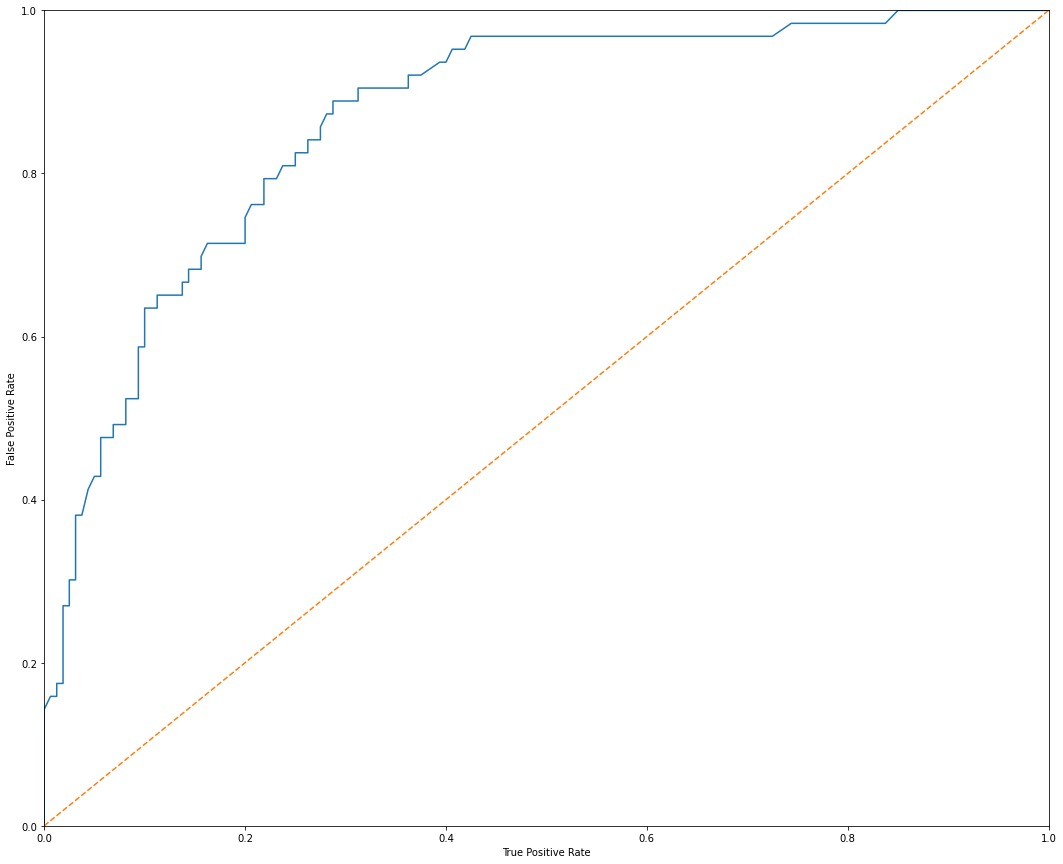

In [105]:

x,y,o = roc_curve(y_test, prediction)
plt.figure(1, figsize=(18,15))
plt.plot(x, y)
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel('True Positive Rate')
plt.ylabel('False Positive Rate')
plt.xlim([0,1])
plt.ylim([0,1])
